<a href="https://colab.research.google.com/github/ArvindReddyC/HydrogenAbsorption/blob/main/HydrogenAbsorptionModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mouting the google Drive 
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Importing  Modules 

In [211]:
from pickle import dump
from xgboost import XGBClassifier, plot_importance,XGBRegressor
from sklearn import linear_model, decomposition, datasets,svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import os
import warnings
from keras import layers
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score

from keras.models import Sequential, Model
from keras.callbacks import Callback
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D,Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.callbacks import ModelCheckpoint

import tensorflow
from tensorflow.keras.optimizers import Adam, SGD
import keras
from sklearn.metrics import roc_auc_score
import joblib

import importlib
import json
from urllib.request import urlopen
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import average_precision_score, precision_score
from sklearn.decomposition import PCA

# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

import seaborn as sb
import matplotlib.pyplot as mp

## Data Engineering


In [73]:
#Reading Data
df1 = pd.read_csv('/content/drive/MyDrive/Code/next100k_new.csv', index_col=0)
df2 = pd.read_csv('/content/drive/MyDrive/Code/next50k_new.csv', index_col=0)
df3 = pd.read_csv('/content/drive/MyDrive/Code/FIrst50K_new.csv', index_col=0)
fullDataset = pd.concat([df1, df2,df3])
display(fullDataset.head(5))

# allElementsDf = pd.read_csv('/content/drive/MyDrive/H2Abs_data/fulldataset.csv')
# allElementsDf.shape

#Getting Column names
columnNames = pd.read_csv("column_names.csv")
numColumns = columnNames.shape[1]
columnNames =  columnNames.iloc[:, 1:numColumns]
columnNames


#FeatureEngineering the class variable
fullDataset["class"] = fullDataset["isotherm1_absorption"]/10
fullDataset["class"] = np.round(fullDataset["class"],0)
fullDataset["class"]

#removing unneccessery variables
numColumns = fullDataset.shape[1]
featureCols = fullDataset.iloc[:, 0:numColumns-8]

#assigning column names to feature variables 
featureCols.columns = columnNames.columns
display(featureCols.head(5))


#gettting predictands 

outcomeVariables = [fullDataset.isotherm0_absorption, 
                    fullDataset.isotherm1_absorption] #since there are two outcome variables to choose from
outcomeVariablesNames = ['isotherm0', 'isotherm1']
choiceOutcomeVariable = 1
predictand = outcomeVariables[choiceOutcomeVariable]
predictandName = outcomeVariablesNames[choiceOutcomeVariable]

reuseModels = False
reusingData = True


,mean_atomic_numbers,max_atomic_numbers,min_atomic_numbers,std_atomic_numbers,volume_per_atom,empty_volume,metals_fraction,mean_distance_matrix,max_distance_matrix,min_distance_matrix,...,SG_221,SG_222,SG_223,SG_224,SG_225,SG_226,SG_227,SG_228,SG_229,SG_230
0,4.883721,29,1,4.555647,39.023801,3277.549625,0.023256,6.188692,12.475569,0.0,...,0,0,0,0,0,0,0,0,0,0
1,4.883721,29,1,4.555647,19.511900,1599.526188,0.023256,5.396183,8.940792,0.0,...,0,0,0,0,0,0,0,0,0,0
2,4.883721,29,1,4.555647,39.023801,3277.549634,0.023256,6.160215,12.142884,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4.883721,29,1,4.555647,19.511900,1599.526192,0.023256,5.430824,8.864004,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5.050000,29,1,4.636540,41.950586,3277.775820,0.025000,6.206907,12.355136,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7.769231,30,1,6.755668,15.169016,660.603429,0.076923,4.222384,6.498430,0.0,...,0,0,0,0,0,0,0,0,0,0
49996,7.849057,30,1,6.631532,29.765616,1448.231770,0.075472,4.839415,8.339986,0.0,...,0,0,0,0,0,0,0,0,0,0
49997,7.849057,30,1,6.631532,14.882808,659.442937,0.075472,4.235235,6.498430,0.0,...,0,0,0,0,0,0,0,0,0,0
49998,8.071429,30,1,6.267425,28.171030,1444.750294,0.071429,4.886040,8.339986,0.0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
fullDataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,323,324,file_id,id,name,isotherm0_pressure,isotherm0_absorption,isotherm1_pressure,isotherm1_absorption,class
0,4.883721,29,1,4.555647,39.023801,3277.549625,0.023256,6.188692,12.475569,0.0,...,0,0,hMOF-5059532.json,118460,hMOF-5059532.json,2,11.18890,100,52.9402,5.0
1,4.883721,29,1,4.555647,19.511900,1599.526188,0.023256,5.396183,8.940792,0.0,...,0,0,hMOF-5059533.json,118464,hMOF-5059533.json,2,28.95780,100,42.2076,4.0
2,4.883721,29,1,4.555647,39.023801,3277.549634,0.023256,6.160215,12.142884,0.0,...,0,0,hMOF-5059534.json,118463,hMOF-5059534.json,2,10.92250,100,52.9497,5.0
3,4.883721,29,1,4.555647,19.511900,1599.526192,0.023256,5.430824,8.864004,0.0,...,0,0,hMOF-5059535.json,118467,hMOF-5059535.json,2,30.04520,100,44.3635,4.0
4,5.050000,29,1,4.636540,41.950586,3277.775820,0.025000,6.206907,12.355136,0.0,...,0,0,hMOF-5059536.json,118466,hMOF-5059536.json,2,9.46018,100,53.0961,5.0


### Correlation Matrix

In [94]:
def MakeCorrelationMatrix( features , predictand ):
    features['predictand'] = predictand
    corr_matrix =  features.corr()
    correlation_toY = corr_matrix.loc['isotherm1_absorption']
    np.where( correlation_toY > 0.50 )[0]
    importantFeatureCols.iloc[ : , np.where( correlation_toY > 0.50 )[0] ]


In [143]:
importantFeatureCols['isotherm1_absorption'] = fullDataset.isotherm1_absorption
importantFeatureCols
corr_matrix =   importantFeatureCols.corr()

,mean_atomic_numbers,max_atomic_numbers,min_atomic_numbers,std_atomic_numbers,volume_per_atom,empty_volume,metals_fraction,mean_distance_matrix,max_distance_matrix,std_distance_matrix,...,SG_65,SG_69,SG_71,SG_119,SG_146,SG_157,SG_160,SG_216,SG_225,isotherm1_absorption
0,4.883721,29,1,4.555647,39.023801,3277.549625,0.023256,6.188692,12.475569,2.369199,...,0,0,0,0,0,0,0,0,0,52.94020
1,4.883721,29,1,4.555647,19.511900,1599.526188,0.023256,5.396183,8.940792,1.818501,...,0,0,0,0,0,0,0,0,0,42.20760
2,4.883721,29,1,4.555647,39.023801,3277.549634,0.023256,6.160215,12.142884,2.359674,...,0,0,0,0,0,0,0,0,0,52.94970
3,4.883721,29,1,4.555647,19.511900,1599.526192,0.023256,5.430824,8.864004,1.816618,...,0,0,0,0,0,0,0,0,0,44.36350
4,5.050000,29,1,4.636540,41.950586,3277.775820,0.025000,6.206907,12.355136,2.395188,...,0,0,0,0,0,0,0,0,0,53.09610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7.769231,30,1,6.755668,15.169016,660.603429,0.076923,4.222384,6.498430,1.333048,...,0,0,0,0,0,0,0,0,0,15.98040
49996,7.849057,30,1,6.631532,29.765616,1448.231770,0.075472,4.839415,8.339986,1.772153,...,0,0,0,0,0,0,0,0,0,43.34620
49997,7.849057,30,1,6.631532,14.882808,659.442937,0.075472,4.235235,6.498430,1.330962,...,0,0,0,0,0,0,0,0,0,18.63540
49998,8.071429,30,1,6.267425,28.171030,1444.750294,0.071429,4.886040,8.339986,1.742237,...,0,0,0,0,0,0,0,0,0,40.70470


In [104]:
corr_matrix.iloc[ np.where( (correlation_toY > 0.10) | (correlation_toY < -0.10)  )[0] , np.where( (correlation_toY > 0.10) | (correlation_toY < -0.10)  )[0] ]

,mean_atomic_numbers,min_atomic_numbers,std_atomic_numbers,volume_per_atom,empty_volume,metals_fraction,mean_distance_matrix,max_distance_matrix,std_distance_matrix,mean_van_der_waals_radius,...,min_average_ionic_radius,std_average_ionic_radius,max_average_cationic_radius,std_average_cationic_radius,mean_average_anionic_radius,std_average_anionic_radius,SG_1,SG_2,SG_12,isotherm1_absorption
mean_atomic_numbers,1.000000,0.260173,0.854018,0.138185,-0.139556,0.559585,-0.245799,-0.267464,-0.198924,0.868259,...,0.260173,0.267173,0.057173,0.590779,0.815112,0.854849,-0.195803,0.017358,0.094537,-0.220558
min_atomic_numbers,0.260173,1.000000,0.047506,0.006583,-0.130511,0.518238,-0.280350,-0.263052,-0.222696,0.363354,...,1.000000,0.113014,-0.087797,0.347276,0.301301,0.118418,-0.593187,0.091050,0.386687,-0.196305
std_atomic_numbers,0.854018,0.047506,1.000000,0.074923,-0.094785,0.381347,-0.144049,-0.165377,-0.141685,0.534818,...,0.047506,0.283865,0.182200,0.630068,0.519474,0.647436,-0.041610,-0.008401,0.000070,-0.139983
volume_per_atom,0.138185,0.006583,0.074923,1.000000,0.658043,0.016717,0.569697,0.625124,0.688085,0.215088,...,0.006583,-0.038814,0.176964,-0.004128,0.079620,0.135097,-0.012988,-0.060356,-0.068899,0.537461
empty_volume,-0.139556,-0.130511,-0.094785,0.658043,1.000000,-0.273998,0.853953,0.831940,0.795284,-0.120698,...,-0.130511,-0.185142,0.109273,-0.238521,-0.174445,-0.129188,0.144697,-0.060330,-0.082957,0.355244
metals_fraction,0.559585,0.518238,0.381347,0.016717,-0.273998,1.000000,-0.479201,-0.470007,-0.401864,0.559017,...,0.518238,0.572536,0.106418,0.888215,0.554482,0.368330,-0.386232,0.071614,0.196145,-0.298079
mean_distance_matrix,-0.245799,-0.280350,-0.144049,0.569697,0.853953,-0.479201,1.000000,0.963387,0.935136,-0.228797,...,-0.280350,-0.297744,0.180291,-0.400162,-0.315579,-0.213642,0.287917,-0.117119,-0.163385,0.565126
max_distance_matrix,-0.267464,-0.263052,-0.165377,0.625124,0.831940,-0.470007,0.963387,1.000000,0.966169,-0.257504,...,-0.263052,-0.285787,0.144307,-0.392118,-0.322094,-0.232996,0.273751,-0.119680,-0.166208,0.610916
std_distance_matrix,-0.198924,-0.222696,-0.141685,0.688085,0.795284,-0.401864,0.935136,0.966169,1.000000,-0.162446,...,-0.222696,-0.243055,0.123971,-0.347241,-0.250132,-0.160442,0.218935,-0.109265,-0.146767,0.639722
mean_van_der_waals_radius,0.868259,0.363354,0.534818,0.215088,-0.120698,0.559017,-0.228797,-0.257504,-0.162446,1.000000,...,0.363354,0.155032,0.016092,0.396656,0.781103,0.784475,-0.308405,0.061181,0.157411,-0.184059


In [101]:
correlation_toY = corr_matrix.loc['isotherm1_absorption']
np.where( correlation_toY > 0.50 )[0]
importantFeatureCols.iloc[ : , np.where( (correlation_toY > 0.10) | (correlation_toY < -0.10)  )[0] ]


,mean_atomic_numbers,min_atomic_numbers,std_atomic_numbers,volume_per_atom,empty_volume,metals_fraction,mean_distance_matrix,max_distance_matrix,std_distance_matrix,mean_van_der_waals_radius,...,min_average_ionic_radius,std_average_ionic_radius,max_average_cationic_radius,std_average_cationic_radius,mean_average_anionic_radius,std_average_anionic_radius,SG_1,SG_2,SG_12,isotherm1_absorption
0,4.883721,1,4.555647,39.023801,3277.549625,0.023256,6.188692,12.475569,2.369199,1.462558,...,0.0,0.357817,0.82,0.178392,0.147907,0.407834,1,0,0,52.94020
1,4.883721,1,4.555647,19.511900,1599.526188,0.023256,5.396183,8.940792,1.818501,1.462558,...,0.0,0.357817,0.82,0.178392,0.147907,0.407834,1,0,0,42.20760
2,4.883721,1,4.555647,39.023801,3277.549634,0.023256,6.160215,12.142884,2.359674,1.462558,...,0.0,0.357817,0.82,0.178392,0.147907,0.407834,1,0,0,52.94970
3,4.883721,1,4.555647,19.511900,1599.526192,0.023256,5.430824,8.864004,1.816618,1.462558,...,0.0,0.357817,0.82,0.178392,0.147907,0.407834,1,0,0,44.36350
4,5.050000,1,4.636540,41.950586,3277.775820,0.025000,6.206907,12.355136,2.395188,1.474750,...,0.0,0.364681,0.82,0.179694,0.159000,0.420760,1,0,0,53.09610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7.769231,1,6.755668,15.169016,660.603429,0.076923,4.222384,6.498430,1.333048,1.583654,...,0.0,0.450232,0.88,0.235158,0.441923,0.607571,1,0,0,15.98040
49996,7.849057,1,6.631532,29.765616,1448.231770,0.075472,4.839415,8.339986,1.772153,1.594340,...,0.0,0.440536,0.88,0.231067,0.458491,0.613556,1,0,0,43.34620
49997,7.849057,1,6.631532,14.882808,659.442937,0.075472,4.235235,6.498430,1.330962,1.594340,...,0.0,0.440536,0.88,0.231067,0.458491,0.613556,1,0,0,18.63540
49998,8.071429,1,6.267425,28.171030,1444.750294,0.071429,4.886040,8.339986,1.742237,1.624107,...,0.0,0.411756,0.88,0.218171,0.504643,0.627626,1,0,0,40.70470


In [204]:
## Making a copy of the important features 103 after removing all the zero values 
impFeatCopy = importantFeatureCols.copy(deep = True)
importantFeatureCols = impFeatCopy.copy(deep = True)

In [ ]:
## Drawing Line Plots check collinearity 
def makeLinePlots(df):
    lines = df.plot.line(subplots=True)

makeLinePlots(impFeatCopy.iloc[:,[1,2,-1]])

#### Experiment 1

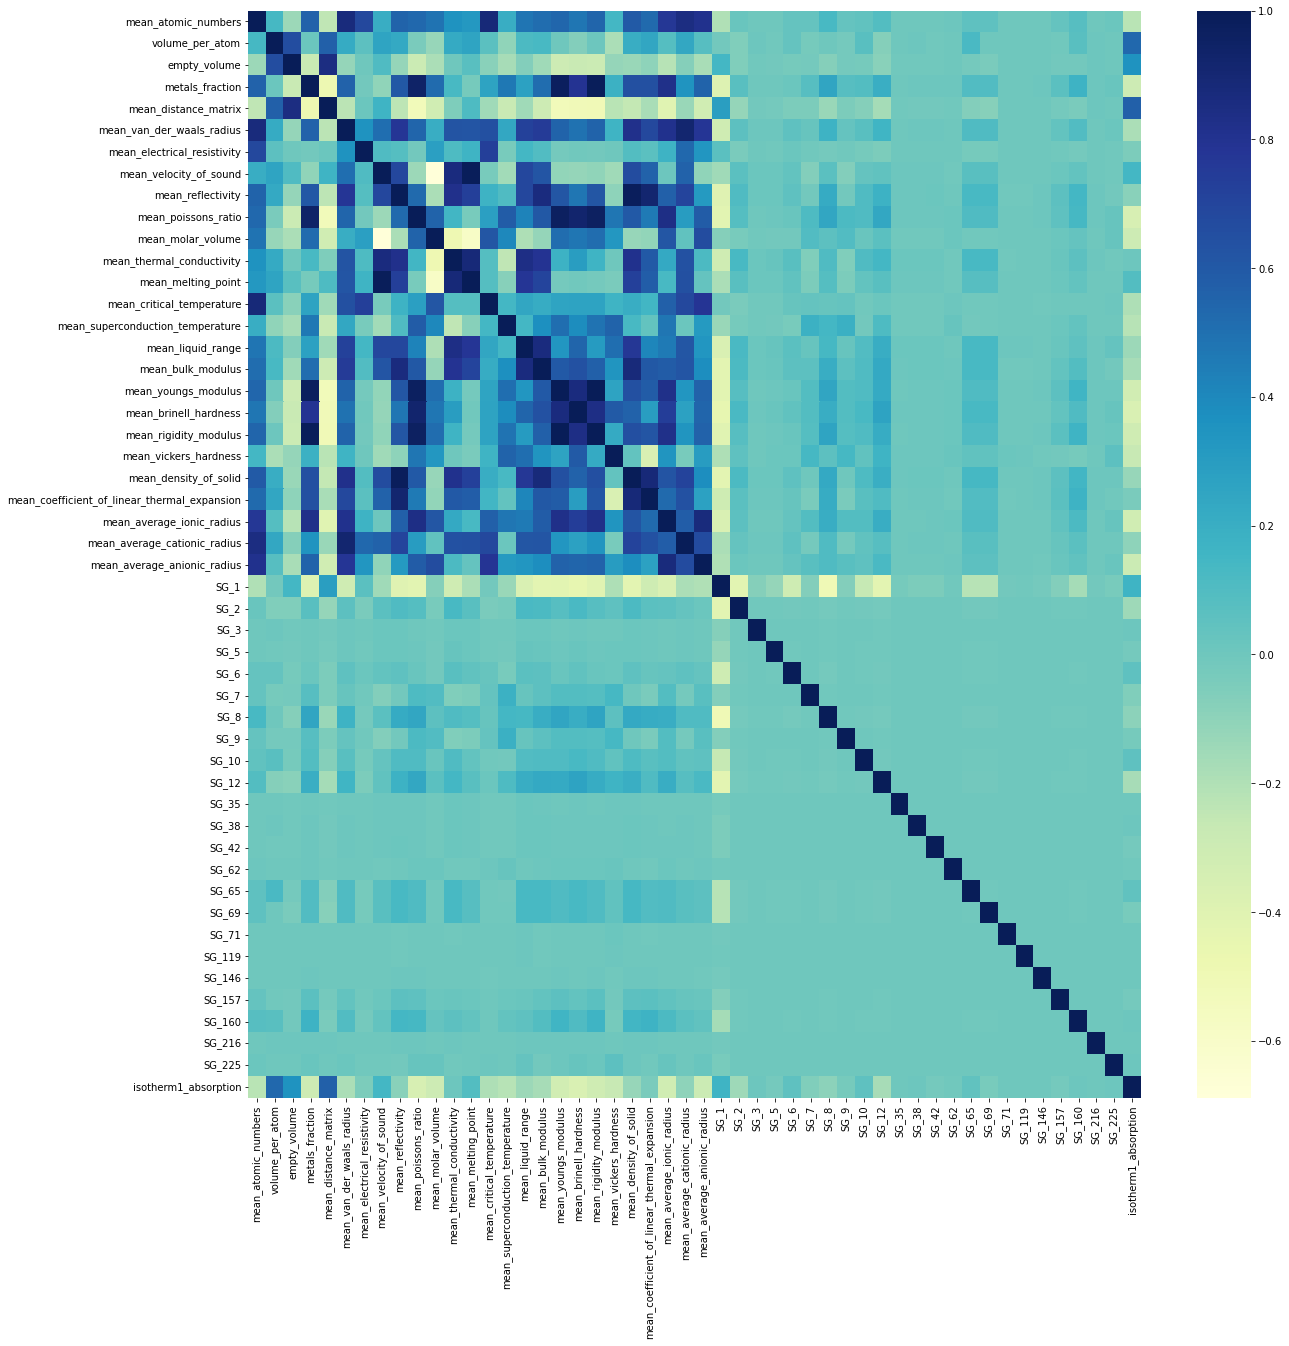

In [218]:
importantFeatureCols = impFeatCopy.copy(deep = True)

importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='min')))]
importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='std')))]
importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='max')))]

#importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='mean')))]


def MakeCorrelationMatrix( df ):
    corr_matrix =  df.corr()
    fig, ax = plt.subplots(figsize=(20,20)) 
    dataplot = sb.heatmap(corr_matrix , cmap="YlGnBu" , ax=ax)  
    mp.show()


MakeCorrelationMatrix(importantFeatureCols)

#predictions , actuall  = scaleMakeEvaluate( 'RF', 50000 , importantFeatureCols[importantFeatureCols.columns.drop('isotherm1_absorption')],importantFeatureCols.isotherm1_absorption ) 

# importantFeatureCols_removedSg = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='SG')))]


# predictions , actuall  = scaleMakeEvaluate( 'RF', 50000 , importantFeatureCols_removedSg[importantFeatureCols_removedSg.columns.drop('isotherm1_absorption')],importantFeatureCols_removedSg.isotherm1_absorption ) 


==================== Results RF ====================
R2 score =  0.9228114469848316
RMSE =  3.896474318242993
MSE =  15.182512112727197


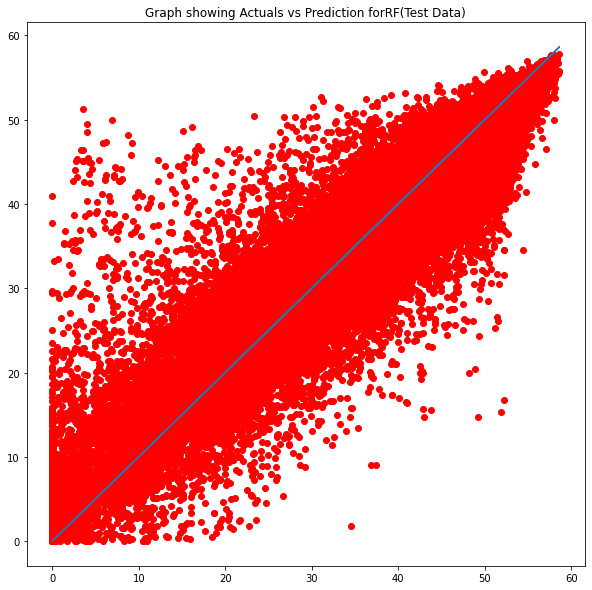

In [220]:
predictions , actuall  = scaleMakeEvaluate( 'RF', 50000 , importantFeatureCols[importantFeatureCols.columns.drop(['isotherm1_absorption','volume_per_atom','mean_distance_matrix'])],importantFeatureCols.isotherm1_absorption ) 


#### experiment 2

==================== Results RF ====================
R2 score =  0.9531429720957912
RMSE =  3.03586697231955
MSE =  9.216488273620673


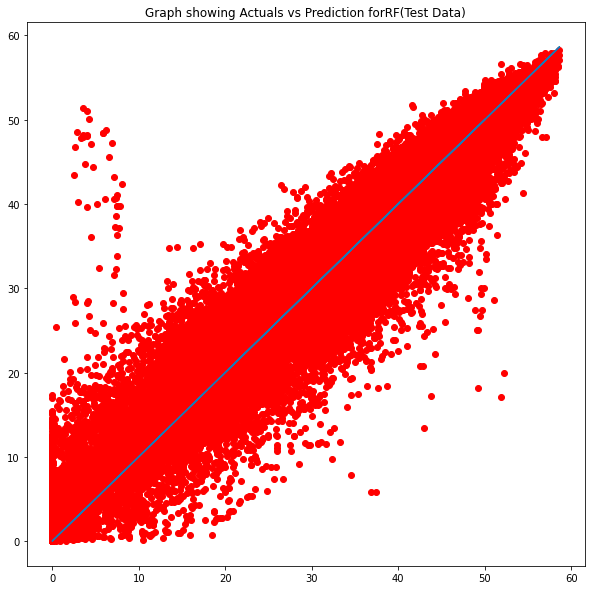

In [207]:
#Experiment description:- this experiment is leaving out the mean value 

importantFeatureCols = impFeatCopy.copy(deep = True)
importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='mean')))]
predictions , actuall  = scaleMakeEvaluate( 'RF', 50000 , importantFeatureCols[importantFeatureCols.columns.drop('isotherm1_absorption')],importantFeatureCols.isotherm1_absorption ) 

#### Experiment 4 

In [215]:
importantFeatureCols
impFeatCopy

,mean_atomic_numbers,max_atomic_numbers,min_atomic_numbers,std_atomic_numbers,volume_per_atom,empty_volume,metals_fraction,mean_distance_matrix,max_distance_matrix,std_distance_matrix,...,SG_65,SG_69,SG_71,SG_119,SG_146,SG_157,SG_160,SG_216,SG_225,isotherm1_absorption
0,4.883721,29,1,4.555647,39.023801,3277.549625,0.023256,6.188692,12.475569,2.369199,...,0,0,0,0,0,0,0,0,0,52.94020
1,4.883721,29,1,4.555647,19.511900,1599.526188,0.023256,5.396183,8.940792,1.818501,...,0,0,0,0,0,0,0,0,0,42.20760
2,4.883721,29,1,4.555647,39.023801,3277.549634,0.023256,6.160215,12.142884,2.359674,...,0,0,0,0,0,0,0,0,0,52.94970
3,4.883721,29,1,4.555647,19.511900,1599.526192,0.023256,5.430824,8.864004,1.816618,...,0,0,0,0,0,0,0,0,0,44.36350
4,5.050000,29,1,4.636540,41.950586,3277.775820,0.025000,6.206907,12.355136,2.395188,...,0,0,0,0,0,0,0,0,0,53.09610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7.769231,30,1,6.755668,15.169016,660.603429,0.076923,4.222384,6.498430,1.333048,...,0,0,0,0,0,0,0,0,0,15.98040
49996,7.849057,30,1,6.631532,29.765616,1448.231770,0.075472,4.839415,8.339986,1.772153,...,0,0,0,0,0,0,0,0,0,43.34620
49997,7.849057,30,1,6.631532,14.882808,659.442937,0.075472,4.235235,6.498430,1.330962,...,0,0,0,0,0,0,0,0,0,18.63540
49998,8.071429,30,1,6.267425,28.171030,1444.750294,0.071429,4.886040,8.339986,1.742237,...,0,0,0,0,0,0,0,0,0,40.70470


In [217]:
#Experiment description:- this experiment is leaving out the mean,min,max,std
importantFeatureCols = impFeatCopy.copy(deep = True)

importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='min')))]
importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='std')))]
importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='max')))]
importantFeatureCols = importantFeatureCols[importantFeatureCols.columns.drop(list(importantFeatureCols.filter(regex='mean')))]

MakeCorrelationMatrix(importantFeatureCols)

predictions , actuall  = scaleMakeEvaluate( 'XGB', 50000 , importantFeatureCols[importantFeatureCols.columns.drop('isotherm1_absorption')],importantFeatureCols.isotherm1_absorption ) 

,volume_per_atom,empty_volume,metals_fraction,SG_1,SG_2,SG_3,SG_5,SG_6,SG_7,SG_8,...,SG_65,SG_69,SG_71,SG_119,SG_146,SG_157,SG_160,SG_216,SG_225,isotherm1_absorption
0,39.023801,3277.549625,0.023256,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,52.94020
1,19.511900,1599.526188,0.023256,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,42.20760
2,39.023801,3277.549634,0.023256,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,52.94970
3,19.511900,1599.526192,0.023256,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44.36350
4,41.950586,3277.775820,0.025000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53.09610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,15.169016,660.603429,0.076923,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15.98040
49996,29.765616,1448.231770,0.075472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43.34620
49997,14.882808,659.442937,0.075472,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18.63540
49998,28.171030,1444.750294,0.071429,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40.70470


In [154]:
import numpy as np

# Create correlation matrix
corr_matrix = importantFeatureCols.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
remaining = importantFeatureCols.drop(to_drop, axis=1, inplace=True)

,mean_atomic_numbers,max_atomic_numbers,min_atomic_numbers,std_atomic_numbers,volume_per_atom,empty_volume,metals_fraction,mean_distance_matrix,mean_van_der_waals_radius,max_van_der_waals_radius,...,SG_65,SG_69,SG_71,SG_119,SG_146,SG_157,SG_160,SG_216,SG_225,isotherm1_absorption
0,4.883721,29,1,4.555647,39.023801,3277.549625,0.023256,6.188692,1.462558,1.96,...,0,0,0,0,0,0,0,0,0,52.94020
1,4.883721,29,1,4.555647,19.511900,1599.526188,0.023256,5.396183,1.462558,1.96,...,0,0,0,0,0,0,0,0,0,42.20760
2,4.883721,29,1,4.555647,39.023801,3277.549634,0.023256,6.160215,1.462558,1.96,...,0,0,0,0,0,0,0,0,0,52.94970
3,4.883721,29,1,4.555647,19.511900,1599.526192,0.023256,5.430824,1.462558,1.96,...,0,0,0,0,0,0,0,0,0,44.36350
4,5.050000,29,1,4.636540,41.950586,3277.775820,0.025000,6.206907,1.474750,1.96,...,0,0,0,0,0,0,0,0,0,53.09610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,7.769231,30,1,6.755668,15.169016,660.603429,0.076923,4.222384,1.583654,2.01,...,0,0,0,0,0,0,0,0,0,15.98040
49996,7.849057,30,1,6.631532,29.765616,1448.231770,0.075472,4.839415,1.594340,2.01,...,0,0,0,0,0,0,0,0,0,43.34620
49997,7.849057,30,1,6.631532,14.882808,659.442937,0.075472,4.235235,1.594340,2.01,...,0,0,0,0,0,0,0,0,0,18.63540
49998,8.071429,30,1,6.267425,28.171030,1444.750294,0.071429,4.886040,1.624107,2.01,...,0,0,0,0,0,0,0,0,0,40.70470


In [155]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [69]:
corr_matrix = fullDataset.corr()
correlation_toY =  corr_matrix.loc['isotherm1_absorption']
fullDataset.iloc[ : , np.where( correlation_toY > 0.50 )[0] ]

,4,7,8,10,isotherm0_absorption,isotherm1_pressure
0,39.023801,6.188692,12.475569,2.369199,11.188900,100
1,19.511900,5.396183,8.940792,1.818501,28.957800,100
2,39.023801,6.160215,12.142884,2.359674,10.922500,100
3,19.511900,5.430824,8.864004,1.816618,30.045200,100
4,41.950586,6.206907,12.355136,2.395188,9.460180,100
...,...,...,...,...,...,...
49995,15.169016,4.222384,6.498430,1.333048,10.147300,100
49996,29.765616,4.839415,8.339986,1.772153,12.459400,100
49997,14.882808,4.235235,6.498430,1.330962,12.602600,100
49998,28.171030,4.886040,8.339986,1.742237,12.562700,100


## Modelling 

In [5]:
result = []

obs = {}


In [6]:
obs

{}

In [41]:
def evaluate_results(actualls,predictions,model_name):
    global obs
    print( '=' * 20 , 'Results' ,  model_name , '=' * 20  )
    print(  'R2 score = ' ,  r2_score(actualls, predictions) )
    print( 'RMSE = ' ,  mean_squared_error(actualls, predictions, squared=False ))
    print( 'MSE = ' ,  mean_squared_error(actualls, predictions ))
    obs['R2_score'] = r2_score(actualls, predictions)
    obs['RMSE'] = mean_squared_error(actualls, predictions, squared=False )
    obs['MSE'] = mean_squared_error(actualls, predictions )
    print( '=' * 50 )


def scale_values(df):
    scaler = StandardScaler().fit(df)
    scaledFeatureCols = scaler.transform(df)
    return scaledFeatureCols


def performRegression( featuresTrain , predictandTrain , featuresTest  , predictandTest  , modeler , model_name ):    
    modeler.fit(featuresTrain, predictandTrain)
    Predictions = modeler.predict(featuresTest)
    joblib.dump(modeler, model_name + '_Regression.pkl') 
    return Predictions


def VisualiseModelPerformance( actualls , predictions , model_name ):
    plt.figure(figsize=(10, 10))
    plt.plot(actualls, predictions, 'ro')
    plt.plot(actualls, actualls)
    plt.title('Graph showing Actuals vs Prediction for' + model_name + '(Test Data)' )
    plt.show()
    # plt.ylabel('RF')
    # plt.xlabel('DFT')
    #plt.savefig(predictandName + '_' + model_name +'_Regression_Correlation_Train', bbox_inches='tight')

def GetModel(selection):
    models = {
        'RF' : RandomForestRegressor(
                        n_estimators=100, max_depth=100, random_state=0),
        
        'XGB':  XGBRegressor(n_estimators=100, max_depth=100, random_state=0),

        'SVM' : svm.SVR(kernel='rbf', epsilon=0.1, verbose=True) }
    return models[selection]


    

In [40]:
def scaleMakeEvaluate( modelName , sizee  , featureCols ,  predictand  ):
    global obs
    obs = {}
    scaledFeatureCols = scale_values(featureCols)
    obs['NumberOfColums'] = scaledFeatureCols.shape[1]
    TrainingFeaturesScaled, TestFeaturesScaled, trainPredictand, testPredictand = train_test_split(
            scaledFeatureCols, predictand, train_size = ( sizee/ len(scaledFeatureCols) ) , random_state=15)
    obs['modelName'] = modelName 
    obs['test_size'] = sizee
    RegressorModel = GetModel(modelName)
    predictions = performRegression( TrainingFeaturesScaled, trainPredictand ,  TestFeaturesScaled ,  testPredictand , RegressorModel , modelName )
    evaluate_results(testPredictand, predictions ,  modelName )
    VisualiseModelPerformance(testPredictand, predictions ,  modelName )
    result.append( obs )
    return predictions, testPredictand

In [10]:
print( 'minimum =  ' ,  np.min(predictand))
print( 'maximum =  ' ,  np.max(predictand))
  

minimum =   0.0
maximum =   59.6445


1. Since we have 325 variables and not more, what is the AIM of finding the importance of finding the feature importance, any particular reason we are looking to reduce the feature importance .? 

2. More data means more good a model, why are we limiting training to 5000 thousand or less .?  ( any particular reason for it .?? )

3. What is out ultimate goal in finding the important feature variables .? 

4. PCA .?



1. Model building time for 5000 to 75000 is very significant. 

### PCA

In [ ]:
pca = PCA(n_components=100)
pca.fit(featureCols)
results = pca.explained_variance_ratio_
print(np.cumsum(results))

#This means that just by using 3 components we are able to account to 100% of the variance. 

[0.99620155 0.99995938 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


==================== Results RF ====================
R2 score =  0.8573695779067617
RMSE =  5.2761356631087875
MSE =  27.837607535528402


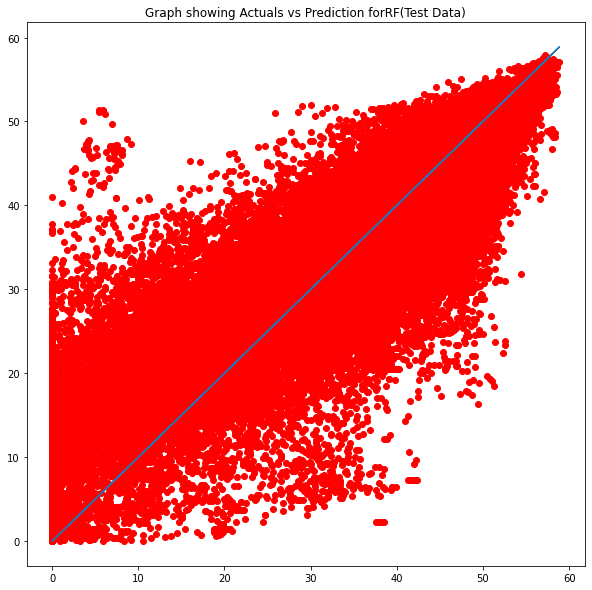

In [ ]:
latentVariables = pca.transform( featureCols )
scaleMakeEvaluate( 'RF', 5000 , latentVariables, predictand ) 


==================== Results RF ====================
R2 score =  0.9140329734072451
RMSE =  4.101953446054599
MSE =  16.826022073599205


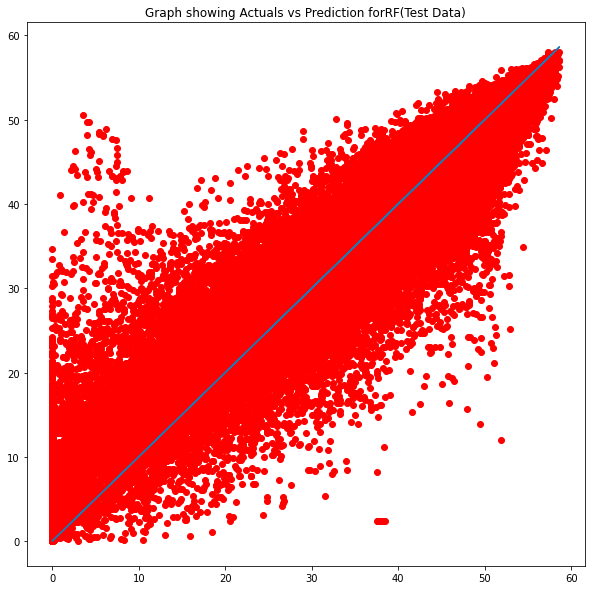

In [ ]:
scaleMakeEvaluate( 'RF', 25000 , latentVariables, predictand ) 

==================== Results RF ====================
R2 score =  0.9607597376251703
RMSE =  2.772536750769775
MSE =  7.686960034369021


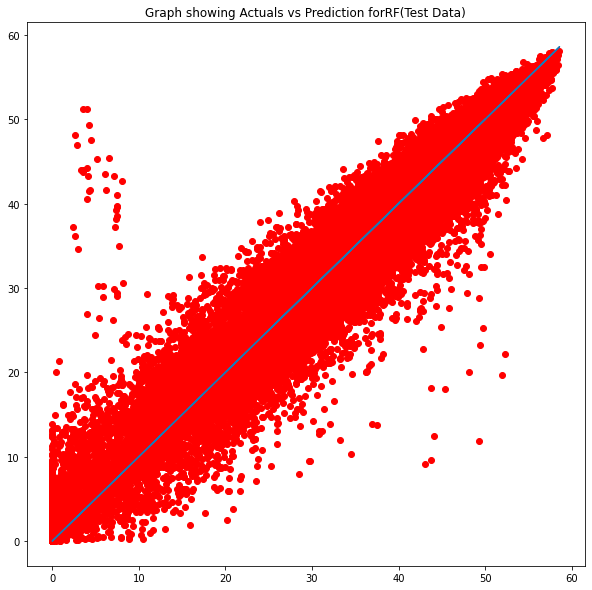

In [ ]:
scaleMakeEvaluate( 'RF', 75000 , latentVariables, predictand ) 

### ALL Models 

In [ ]:
for model in ['XGB', 'RF', 'SVM']:
    scaleMakeEvaluate( model, 5000 , featureCols,predictand ) 


[10:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
==================== Results ====================
R2 score =  0.9356026159823249
RMSE =  3.5452264673887988
MSE =  12.568630705074062
==================== Results ====================
R2 score =  0.9354480386397444
RMSE =  3.549478839060126
MSE =  12.598800028935619
[LibSVM]

###Feature selection using f-meaasure

In [140]:
usefullColumns = featureCols.replace(0,np.nan).dropna(axis=1,how="all").columns
importantFeatureCols = featureCols[usefullColumns] 

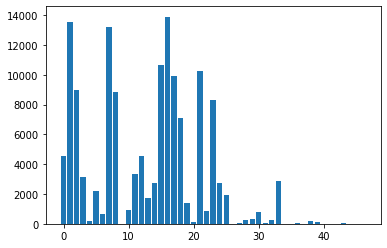

0.01468608573781405
13905.064790581744


In [221]:


# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs



#predictions , actuall  = scaleMakeEvaluate( 'RF', 50000 , importantFeatureCols[importantFeatureCols.columns.drop(['isotherm1_absorption','volume_per_atom','mean_distance_matrix'])],importantFeatureCols.isotherm1_absorption ) 


X_train, X_test, y_train, y_test = train_test_split(importantFeatureCols[importantFeatureCols.columns.drop(['isotherm1_absorption','volume_per_atom','mean_distance_matrix'])] ,  importantFeatureCols.isotherm1_absorption , test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
# for i in range(len(fs.scores_)):
# 	print('Feature %d: %f' % (i, c[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

print(np.min(fs.scores_))
print(np.max(fs.scores_))


# fMeasureSelected4000   =   importantFeatureCols_removedSg.iloc[ : ,  np.where(fs.scores_ > 25000 )[0]]


# predictions , actuall  = scaleMakeEvaluate( 'RF', 50000 , fMeasureSelected4000,predictand ) 


In [59]:
fMeasureSelected4000

,volume_per_atom,mean_distance_matrix,max_distance_matrix,min_distance_matrix
0,39.023801,6.188692,12.475569,0.0
1,19.511900,5.396183,8.940792,0.0
2,39.023801,6.160215,12.142884,0.0
3,19.511900,5.430824,8.864004,0.0
4,41.950586,6.206907,12.355136,0.0
...,...,...,...,...
49995,15.169016,4.222384,6.498430,0.0
49996,29.765616,4.839415,8.339986,0.0
49997,14.882808,4.235235,6.498430,0.0
49998,28.171030,4.886040,8.339986,0.0


In [53]:
fMeasureSelected4000['isotherm1'] = predictand
fMeasureSelected4000.drop('isotherm1' , axis = 1  ).corr(fMeasureSelected4000['isotherm1'])
result

0        52.94020
1        42.20760
2        52.94970
3        44.36350
4        53.09610
           ...   
49995    15.98040
49996    43.34620
49997    18.63540
49998    40.70470
49999     2.14667
Name: isotherm1_absorption, Length: 137953, dtype: float64

### Code by Poojith

[02:20:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------

XGBOOST Test isotherm1 MSE	12.640176144754834

XGBOOST Test isotherm1 RMSE	3.555302539131492

XGBOOST Test isotherm1 R2	0.9352428654290801

XGBOOST Train isotherm1 MSE	0.001076748346231336

XGBOOST Train isotherm1 RMSE	0.032813843819816904

XGBOOST Train isotherm1 R2	0.9999945220041967

--------------------------------------------------

--------------------------------------------------

RF Test isotherm1 MSE	12.658806045352549

RF Test isotherm1 RMSE	3.557921590669551

RF Test isotherm1 R2	0.9351474222195683

RF Train isotherm1 MSE	1.9858274137243057

RF Train isotherm1 RMSE	1.4091938879104982

RF Train isotherm1 R2	0.9898970318584241

--------------------------------------------------

[LibSVM]--------------------------------------------------

SVM Test isotherm1 MSE	88.67687216888064

SVM Test isotherm1 RM

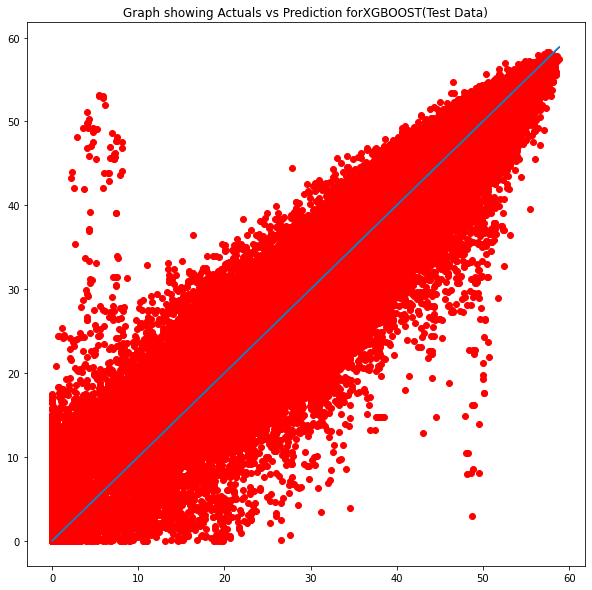

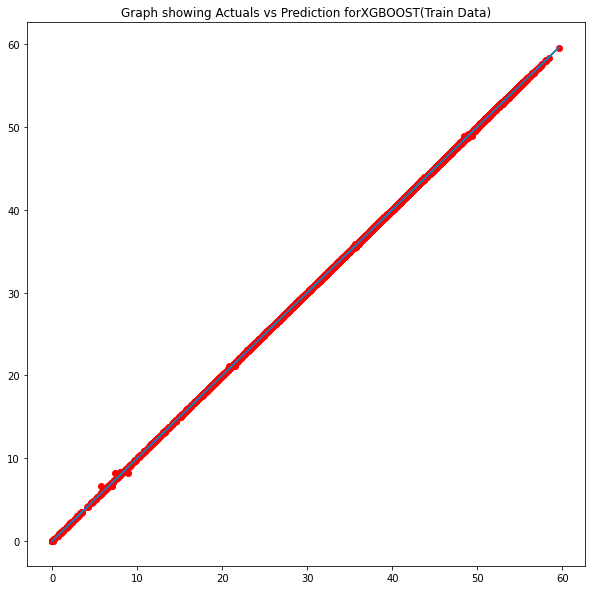

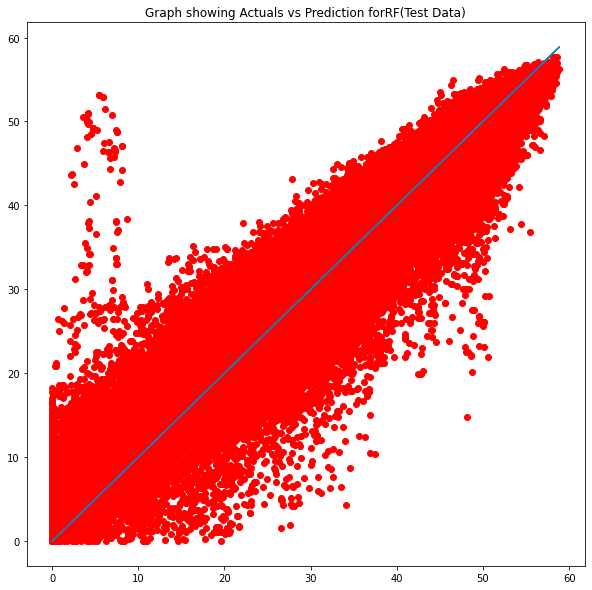

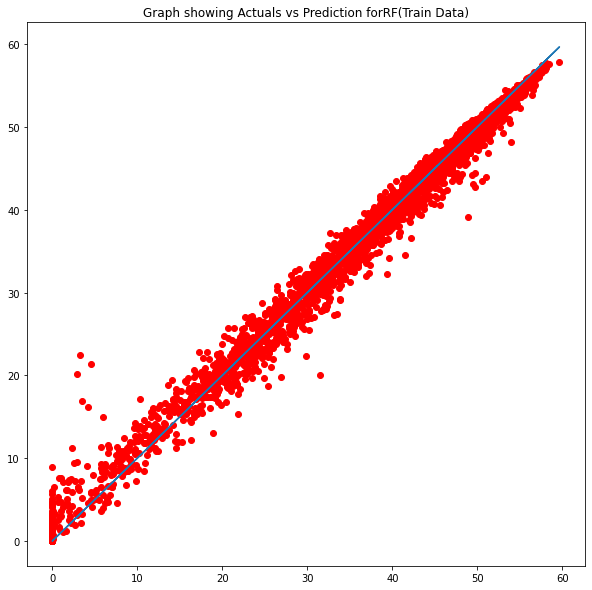

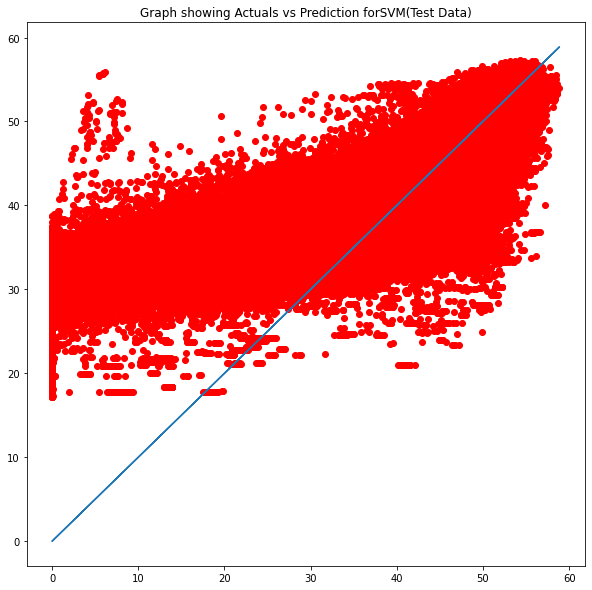

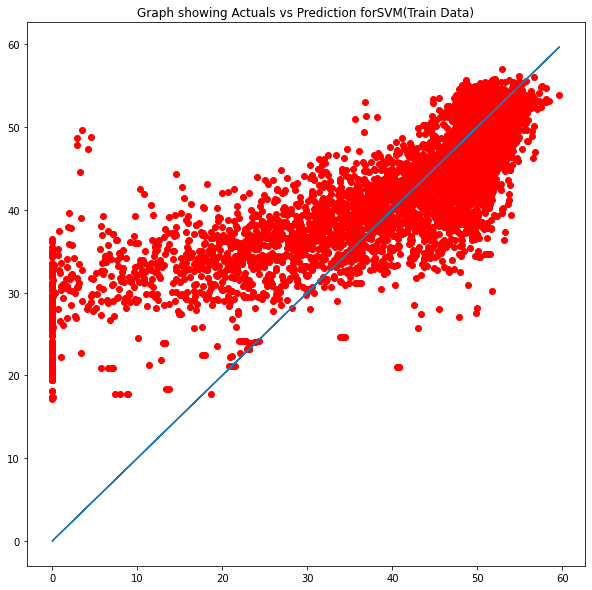

In [ ]:
for regr_choice in range(0, 3):
    regr_names = ['XGBOOST', 'RF', 'SVM']
    regr_objects = [XGBRegressor(n_estimators=100, max_depth=100, random_state=0),
                    RandomForestRegressor(
                        n_estimators=100, max_depth=100, random_state=0),
                    svm.SVR(kernel='rbf', epsilon=0.1, verbose=True)
                    # RVR(kernel='rbf', n_iter=10000, tol=0.0001, verbose=True),
                    # linear_model.HuberRegressor(
                    #     epsilon=1.35, max_iter=100, alpha=0.0001, warm_start=False, fit_intercept=True, tol=1e-05),

                    ]

    regr = regr_objects[regr_choice]
    regr_name = regr_names[regr_choice]

    regr.fit( TrainingFeaturesScaled , trainPredictand)

    y_predicted = regr.predict(TestFeaturesScaled)

    print('-'*50 + '\n' )
     
      
    print(regr_name+' Test '+predictandName+' MSE\t' +
          str(mean_squared_error(testPredictand, y_predicted))+'\n')
    print(regr_name +' Test '+predictandName+' RMSE\t' +
          str(mean_squared_error(testPredictand, y_predicted, squared=False ))+'\n')
    print(regr_name+' Test '+predictandName+' R2\t' +
          str(r2_score(testPredictand, y_predicted))+'\n')

    

    xPlot = testPredictand
    yPlot = y_predicted
    plt.figure(figsize=(10, 10))
    plt.plot(xPlot, yPlot, 'ro')
    plt.plot(xPlot, xPlot)
    plt.title('Graph showing Actuals vs Prediction for' + regr_name + '(Test Data)' )
    # plt.ylabel('RF')
    # plt.xlabel('DFT')
    plt.savefig(predictandName +'_'+regr_name +
                '_Regression_Correlation_Test', bbox_inches='tight')

    y_predicted = regr.predict(TrainingFeaturesScaled)

    print(regr_name+' Train '+predictandName+' MSE\t' +
          str(mean_squared_error(trainPredictand, y_predicted))+'\n')
    
    print(regr_name +' Train '+predictandName+' RMSE\t' +
          str(mean_squared_error(trainPredictand, y_predicted, squared=False ))+'\n')
    
    print(regr_name+' Train '+predictandName+' R2\t' +
          str(r2_score(trainPredictand, y_predicted))+'\n')

    print('-'*50 + '\n' )
    xPlot = trainPredictand
    yPlot = y_predicted
    plt.figure(figsize=(10, 10))
    plt.plot(xPlot, yPlot, 'ro')
    plt.plot(xPlot, xPlot)
    plt.title('Graph showing Actuals vs Prediction for' + regr_name + '(Train Data)' )
    # plt.ylabel('RF')
    # plt.xlabel('DFT')
    plt.savefig(predictandName+'_'+regr_name +
                '_Regression_Correlation_Train', bbox_inches='tight')

    joblib.dump(regr, predictandName +
                '_'+ regr_name +'_Regression.pkl') 

### Randon Forest Classifier 

In [ ]:


# numColumns = fullDataset.shape[1]

# X = fullDataset.iloc[:, 0:numColumns-7]
# #X.columns = column_names.columns

# y_list = [full_dataset_df.isotherm0_absorption,
#           full_dataset_df.isotherm1_absorption]
# y_names = ['isotherm0', 'isotherm1']

# choice = 1
# y = y_list[choice]
# y_name = full_dataset_df["isotherm1_absorption"]

# X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
#         X, y, test_size=.981, random_state=15)
# scaler = StandardScaler().fit(X_train_scaled)
# X_train_scaled = scaler.transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)



RandomForestRegr = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=0)
RandomForestRegr.fit( TrainingFeaturesScaled  , trainPredictand )
y_predicted = m.predict( TestFeaturesScaled )

r2 = r2_score( testPredictand , y_predicted)
print('\n--------R2=', r2)


print(regr_name +' Test '+predictandName+' RMSE\t' + str(mean_squared_error(testPredictand, y_predicted, squared=False ))+'\n')



--------R2= 0.9352428654290801
SVM Test isotherm1 RMSE	3.555302539131492



In [ ]:
featureImportances = RandomForestRegr.feature_importances_
#important Feature Variables
columnNames.columns[ list(np.where(RandomForestRegr.feature_importances_ >= 0.01)[0])]

Index(['mean_atomic_numbers', 'volume_per_atom', 'max_distance_matrix',
       'std_distance_matrix', 'mean_van_der_waals_radius',
       'mean_average_cationic_radius'],
      dtype='object')

### Finding the next important Feature by elimination

In [ ]:

#featureCols_reduced =  featureCols.drop( list(columnNames.columns[ list(np.where(RandomForestRegr.feature_importances_ >= 0.01)[0])]) , axis = 1  )
RandomForestRegr = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=0)
RandomForestRegr.fit( TrainingFeaturesScaled[:,np.where(featureImportances < 0.01)[0]]   , trainPredictand )
y_predicted = RandomForestRegr.predict(  TestFeaturesScaled[:,np.where(featureImportances < 0.01)[0]]  )

r2 = r2_score( testPredictand , y_predicted)
print('-'*50)
print('R2=', r2)


print('Random Forest Regr' +' Test '+predictandName+' RMSE\t' + str(mean_squared_error(testPredictand, y_predicted, squared=False ))+'\n')

featureImportances2 =  RandomForestRegr.feature_importances_
#important Feature Variables
print('-'*50)
columnNames.columns[ list(np.where(RandomForestRegr.feature_importances_ >= 0.01)[0])]

--------------------------------------------------
R2= 0.8959619111553851
Random Forest Regr Test isotherm1 RMSE	4.5063916563571995

--------------------------------------------------


Index(['std_atomic_numbers', 'empty_volume', 'min_superconduction_temperature',
       'min_liquid_range', 'min_coefficient_of_linear_thermal_expansion'],
      dtype='object')

In [ ]:
3 0.7187286599248028 empty_volume
5 0.048054497916286465 mean_distance_matrix
25 0.011031973470643658 std_poissons_ratio
49 0.020982322334397722 std_liquid_range
53 0.016877886856972304 std_bulk_modulus
81 0.018628205440220924 std_average_ionic_radius
84 0.0115045442419903 std_average_cationic_radius

array([[[-0.40991494, -0.21679973, -0.57586972, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 1.59573608, -0.21679973,  3.01860264, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.07563977, -0.21679973, -0.90606433, ...,  0.        ,
          0.        ,  0.        ]],

       ...,

       [[-0.07563977, -0.21679973, -0.95048215, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.40991494, -0.21679973,  0.00650246, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.40991494, -0.21679973, -0.82442253, ...,  0.        ,
          0.        ,  0.        ]]])